# Klein model
> Does the Klein model allow us to circumvent the hyperboloid modifications to decision trees?

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata

from src.hyperdt.tree import HyperbolicDecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier


In [7]:
# Basic sanity check: anndata

import sys

sys.path.append("/home/phil/americangut")
from make_xy import make_anndata_X_y


In [21]:
adata = anndata.read_h5ad(
    "/home/phil/americangut/data/big_table_with_embeddings.h5ad"
)

X_hyp, y_hyp = make_anndata_X_y(
    # column="host_body_habitat",
    column="ibd",
    balance=True,
    embedding="hyp_mix_2",
    adata=adata,
    seed=42,
)
print(X_hyp.shape)

X_poi, y_poi = make_anndata_X_y(
    # column="host_body_habitat",
    column="ibd",
    balance=True,
    embedding="poi_mix_2",
    adata=adata,
    seed=42,
)


(2690, 3)


In [28]:
# Convert to Klein model


def hyperboloid_to_klein(X, timelike_dim=0):
    """Simple make the timelike coordinate equal to 1"""

    # Input validation
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)

    # Put timelike dimension first
    X = np.roll(X, -timelike_dim, axis=1)

    return X[:, 1:] / (1 + X[:, 0, None])


X_klein = hyperboloid_to_klein(X_hyp, timelike_dim=-1)


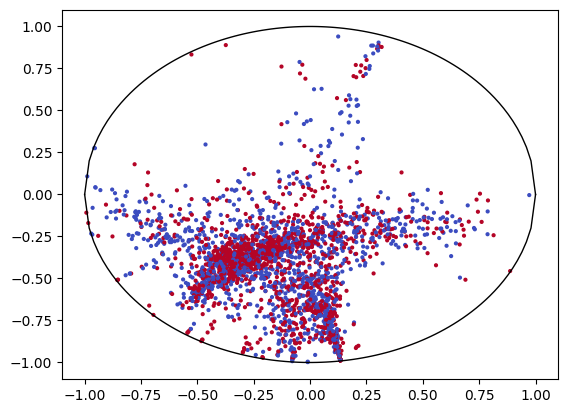

In [30]:
# Plot Klein embeddings
plt.scatter(X_klein[:, 0], X_klein[:, 1], c=y_hyp, cmap="coolwarm", s=4)

# Plot unit circle
x = np.linspace(-1, 1, 100)
y = np.sqrt(1 - x ** 2)
plt.plot(x, y, c="k", linewidth=1)
plt.plot(x, -y, c="k", linewidth=1)


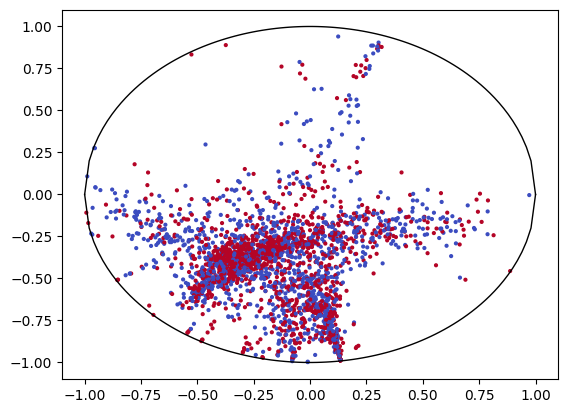

In [33]:
# For reference, plot Poincare embeddings

plt.scatter(X_poi[:, 0], X_poi[:, 1], c=y_poi, cmap="coolwarm", s=4)

# Plot unit circle
x = np.linspace(-1, 1, 100)
y = np.sqrt(1 - x ** 2)
plt.plot(x, y, c="k", linewidth=1)
plt.plot(x, -y, c="k", linewidth=1)


In [43]:
# Compare hdt to dt+Klein

args = {"max_depth": 20}

hdt = HyperbolicDecisionTreeClassifier(timelike_dim=-1, **args)
hdt.fit(X_hyp, y_hyp)
hdt_score = hdt.score(X_hyp, y_hyp)

kdt = DecisionTreeClassifier(**args)
kdt.fit(X_klein, y_hyp)
kleindt_score = kdt.score(X_klein, y_hyp)

print(f"HDT score: {hdt_score}")
print(f"Klein DT score: {kleindt_score}")

# Ok wow... this is a huge difference!


HDT score: 0.5100371747211896
Klein DT score: 0.8427509293680298


In [46]:
# Let's quickly check the IBD data

X_ibd, y_ibd = make_anndata_X_y(
    column="ibd", embedding="hyp_mix_128", balance=True, seed=42, adata=adata
)
X_ibd_klein = hyperboloid_to_klein(X_ibd, timelike_dim=-1)

# Sanity check: everything is inside unit circle
assert np.all(np.linalg.norm(X_ibd_klein, axis=1) <= 1)


In [48]:
# kdt on IBD data
from sklearn.model_selection import train_test_split

X_ibd_klein_train, X_ibd_klein_test, y_train, y_test = train_test_split(
    X_ibd_klein, y_ibd, test_size=0.2, random_state=42
)

kdt_ibd = DecisionTreeClassifier(max_depth=4)

kdt_ibd.fit(X_ibd_klein_train, y_train)

kdt_ibd_score = kdt_ibd.score(X_ibd_klein_test, y_test)
print(f"KDT IBD score: {kdt_ibd_score}")


KDT IBD score: 0.550185873605948


In [52]:
# Does it beat PCA?
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_ibd_pca, y_ibd = make_anndata_X_y(
    adata,
    column="ibd",
    balance=True,
    embedding=None,
    seed=42,
    to_dense=True,
)

X_ibd_pca_train, X_ibd_pca_test, y_ibd_train, y_ibd_test = train_test_split(
    X_ibd_pca, y_ibd, test_size=0.2, random_state=42
)

pca = PCA(n_components=128)

pca.fit(X_ibd_pca_train)

X_ibd_pca_train = pca.transform(X_ibd_pca_train)
X_ibd_pca_test = pca.transform(X_ibd_pca_test)

# Train dt
pca_dt = DecisionTreeClassifier(random_state=42, max_depth=4)
pca_dt.fit(X_ibd_pca_train, y_ibd_train)

# Test dt
pca_dt_score = pca_dt.score(X_ibd_pca_test, y_ibd_test)
print(f"PCA Decision Tree Score: {pca_dt_score}")

# No, PCA seems to do a little bit better...


PCA Decision Tree Score: 0.5855018587360595


In [74]:
# Code to convert Poincare to Klein:


def poincare_to_klein(X):
    """Convert Poincare ball coordinates to Klein coordinates."""
    return 2 * X / (1 + np.linalg.norm(X, axis=1) ** 2)[:, None]


In [71]:
# What if we did a simpler, more hyperbolic classification task?

otu_embeddings_128 = adata.varm["component_embeddings_poincare_128"]
classes = adata.var["taxonomy_1"]
otu_embeddings_128.shape


(37215, 128)

In [75]:
# Get X and y matrices from this
X_train_otu, X_test_otu, y_train, y_test = train_test_split(
    otu_embeddings_128, classes, test_size=0.2, random_state=42
)
# X_train_otu_klein = hyperboloid_to_klein(X_train_otu, timelike_dim=-1)
# X_test_otu_klein = hyperboloid_to_klein(X_test_otu, timelike_dim=-1)
X_train_otu_klein = poincare_to_klein(X_train_otu)
X_test_otu_klein = poincare_to_klein(X_test_otu)

dt1 = DecisionTreeClassifier(max_depth=4)
dt2 = DecisionTreeClassifier(max_depth=4)
# dt3 = HyperbolicDecisionTreeClassifier(max_depth=4, timelike_dim=-1)

dt1.fit(X_train_otu, y_train)
dt2.fit(X_train_otu_klein, y_train)
# dt3.fit(X_train_otu, y_train)

# Scores
dt1_score = dt1.score(X_test_otu, y_test)
dt2_score = dt2.score(X_test_otu_klein, y_test)
# dt3_score = dt3.score(X_test_otu, y_test)

# Print
print(f"Decision tree score: {dt1_score}")
print(f"Klein decision tree score: {dt2_score}")
# print(f"Hyperbolic decision tree score: {dt3_score}")


Decision tree score: 0.7992744860943168
Klein decision tree score: 0.7992744860943168
